# 드라이브 마운트 및 모듈 import



In [ ]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

print("numpy      = ", np.__version__)
print("panda      = ", pd.__version__)
print("tensorflow = ", tf.__version__)
print("matplotlib = ", mpl.__version__)

np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings(action='ignore')

numpy      =  1.21.6
panda      =  1.3.5
tensorflow =  2.8.2
matplotlib =  3.2.2


# 데이터 불러오기, 전처리

In [ ]:
#/content/mnt/MyDrive/python/Financial big data/nonogram/data/
exchangerateData=pd.read_csv('/content/mnt/MyDrive/python/Financial big data/nonogram/data/exchange.csv')     #date column 없음
kospiData=pd.read_csv('/content/mnt/MyDrive/python/Financial big data/nonogram/data/kospi.csv')               #date column 없음
priceData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/priceindex.xlsx')       #date column 없음
unemployData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/unemployment.xlsx')  #date column 없음

ex_inflationData=pd.read_csv('/content/mnt/MyDrive/python/Financial big data/nonogram/data/expected_inflation.csv') #date 2002 02 시작
rateData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/new_rate.xlsx')                #date 1999 05 시작 #new_rate 활용
nxM2FrbData=pd.read_excel('/content/mnt/MyDrive/python/Financial big data/nonogram/data/NX_M2_FRD.xlsx')            #date 1999 05

#Date column이름 변경
ex_inflationData.rename(columns={'Unnamed: 0':'Date','inflation':'Ex_inflation'}, inplace=True)
rateData.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
nxM2FrbData.rename(columns={'Unnamed: 0':'Date','nx':'NX'}, inplace=True)
exchangerateData=exchangerateData[['Close']].rename(columns={'Close':'Exchange_Close'})
kospiData=kospiData[['Close']].rename(columns={'Close':'Kospi_Close'})
priceData=priceData[['Change']].rename(columns={'Change':'Price_Change'})
unemployData=unemployData[['unemployment']].rename(columns={'unemployment':'Unemployment_rate'})

#Date 가져오기
date=rateData[['Date']]

#date 없는 애들 합치기
df_sub=pd.concat([date,exchangerateData,kospiData,priceData,unemployData],axis=1)

#Y data 설정
rateData.loc[rateData['difference'] == 0,'Y']=0     #기준금리 동결 시 0
rateData.loc[rateData['difference'] > 0,'Y']=1      #기준금리 인상 시 1
rateData.loc[rateData['difference'] < 0,'Y']=2      #기준금리 인하 시 2
rateData=rateData[['Date','CD rate','Y']].rename(columns={'CD rate':'CD_rate'})

#index 기준 합치기
df_Main=pd.merge(pd.merge(df_sub,nxM2FrbData),pd.merge(ex_inflationData,rateData))
df_Main=df_Main.dropna() #결측치 삭제

#Date datetime type 변환
df_Main_date=df_Main[['Date']].astype('str')
df_Main_date['Date']=df_Main_date['Date'].apply(lambda _ : dt.datetime.strptime(_,'%Y%m').strftime('%Y-%m'))
df_Main[['Date']]=df_Main_date

#증가율 변환
non_changeColumnsList=['Exchange_Close','Kospi_Close','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']
df_Main[non_changeColumnsList]=df_Main[non_changeColumnsList].pct_change()
df_Main=df_Main.dropna() #증가율 변환 후 결측치 삭제
df_Main.reset_index(drop=True,inplace=True) #결측치 삭제 후 index 재배열

#MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_Main[['Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']])
df_Main.loc[:,1:-1] = scaled_values

#x_data는 전 월, y_data는 후 월 설정
df_data=df_Main[['Date','Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']]
df_baserate=df_Main[['Date','Y']]
df_baserate.rename(columns={'Date':'Y_Date'},inplace=True)

df_edit1=df_data.loc[0:238].reset_index(drop=True)        #2002 03 ~ 2022 01
df_edit2=df_baserate.loc[1:239].reset_index(drop=True)    #2002 04 ~ 2022 02
df_Main_edit=pd.concat([df_edit1,df_edit2],axis=1)        #x_data와 y_data는 1개월 차  

#출력
df_Main_edit

,Date,Exchange_Close,Kospi_Close,Price_Change,Unemployment_rate,NX,M2,FRB_rate,Ex_inflation,CD_rate,Y_Date,Y
0,2002-03,0.496494,0.864266,0.684211,0.239024,0.488579,0.972928,0.444444,0.510795,0.571227,2002-04,0.0
1,2002-04,0.406375,0.459201,0.684211,0.190351,0.453478,0.756939,0.444444,0.580000,0.588845,2002-05,1.0
2,2002-05,0.288043,0.472314,0.578947,0.260784,0.457018,0.730750,0.444444,0.509186,0.540696,2002-06,0.0
3,2002-06,0.458342,0.437948,0.315789,0.207812,0.472251,0.568510,0.444444,0.725000,0.547778,2002-07,0.0
4,2002-07,0.418169,0.529060,0.210526,0.454598,0.462970,0.672980,0.444444,0.233977,0.554713,2002-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
234,2021-09,0.567961,0.509082,0.578947,0.408333,0.477184,0.448436,0.444444,0.580000,1.000000,2021-10,0.0
235,2021-10,0.462067,0.532578,0.473684,0.406173,0.471127,0.637521,0.444444,0.580000,0.708075,2021-11,1.0
236,2021-11,0.515481,0.499603,0.631579,0.241667,0.471958,0.727401,0.444444,0.960625,0.676080,2021-12,0.0
237,2021-12,0.506459,0.748461,0.473684,0.875000,0.472304,0.504753,0.444444,0.467222,0.679734,2022-01,1.0


# 그림 그려보기

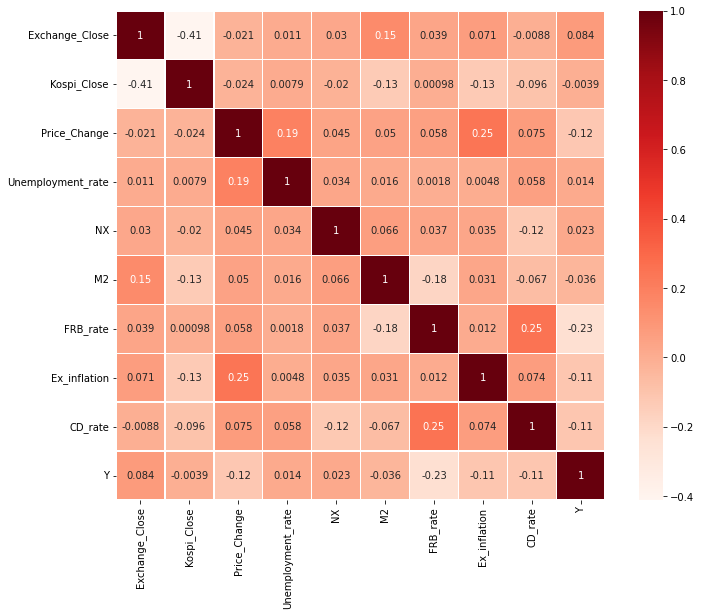

In [ ]:
df_Main_edit=df_Main_edit[['Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate','Y']]
correlation_matrix = df_Main_edit.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,annot=True,square=True, linewidths=.5,cmap=plt.cm.Reds)
plt.show()

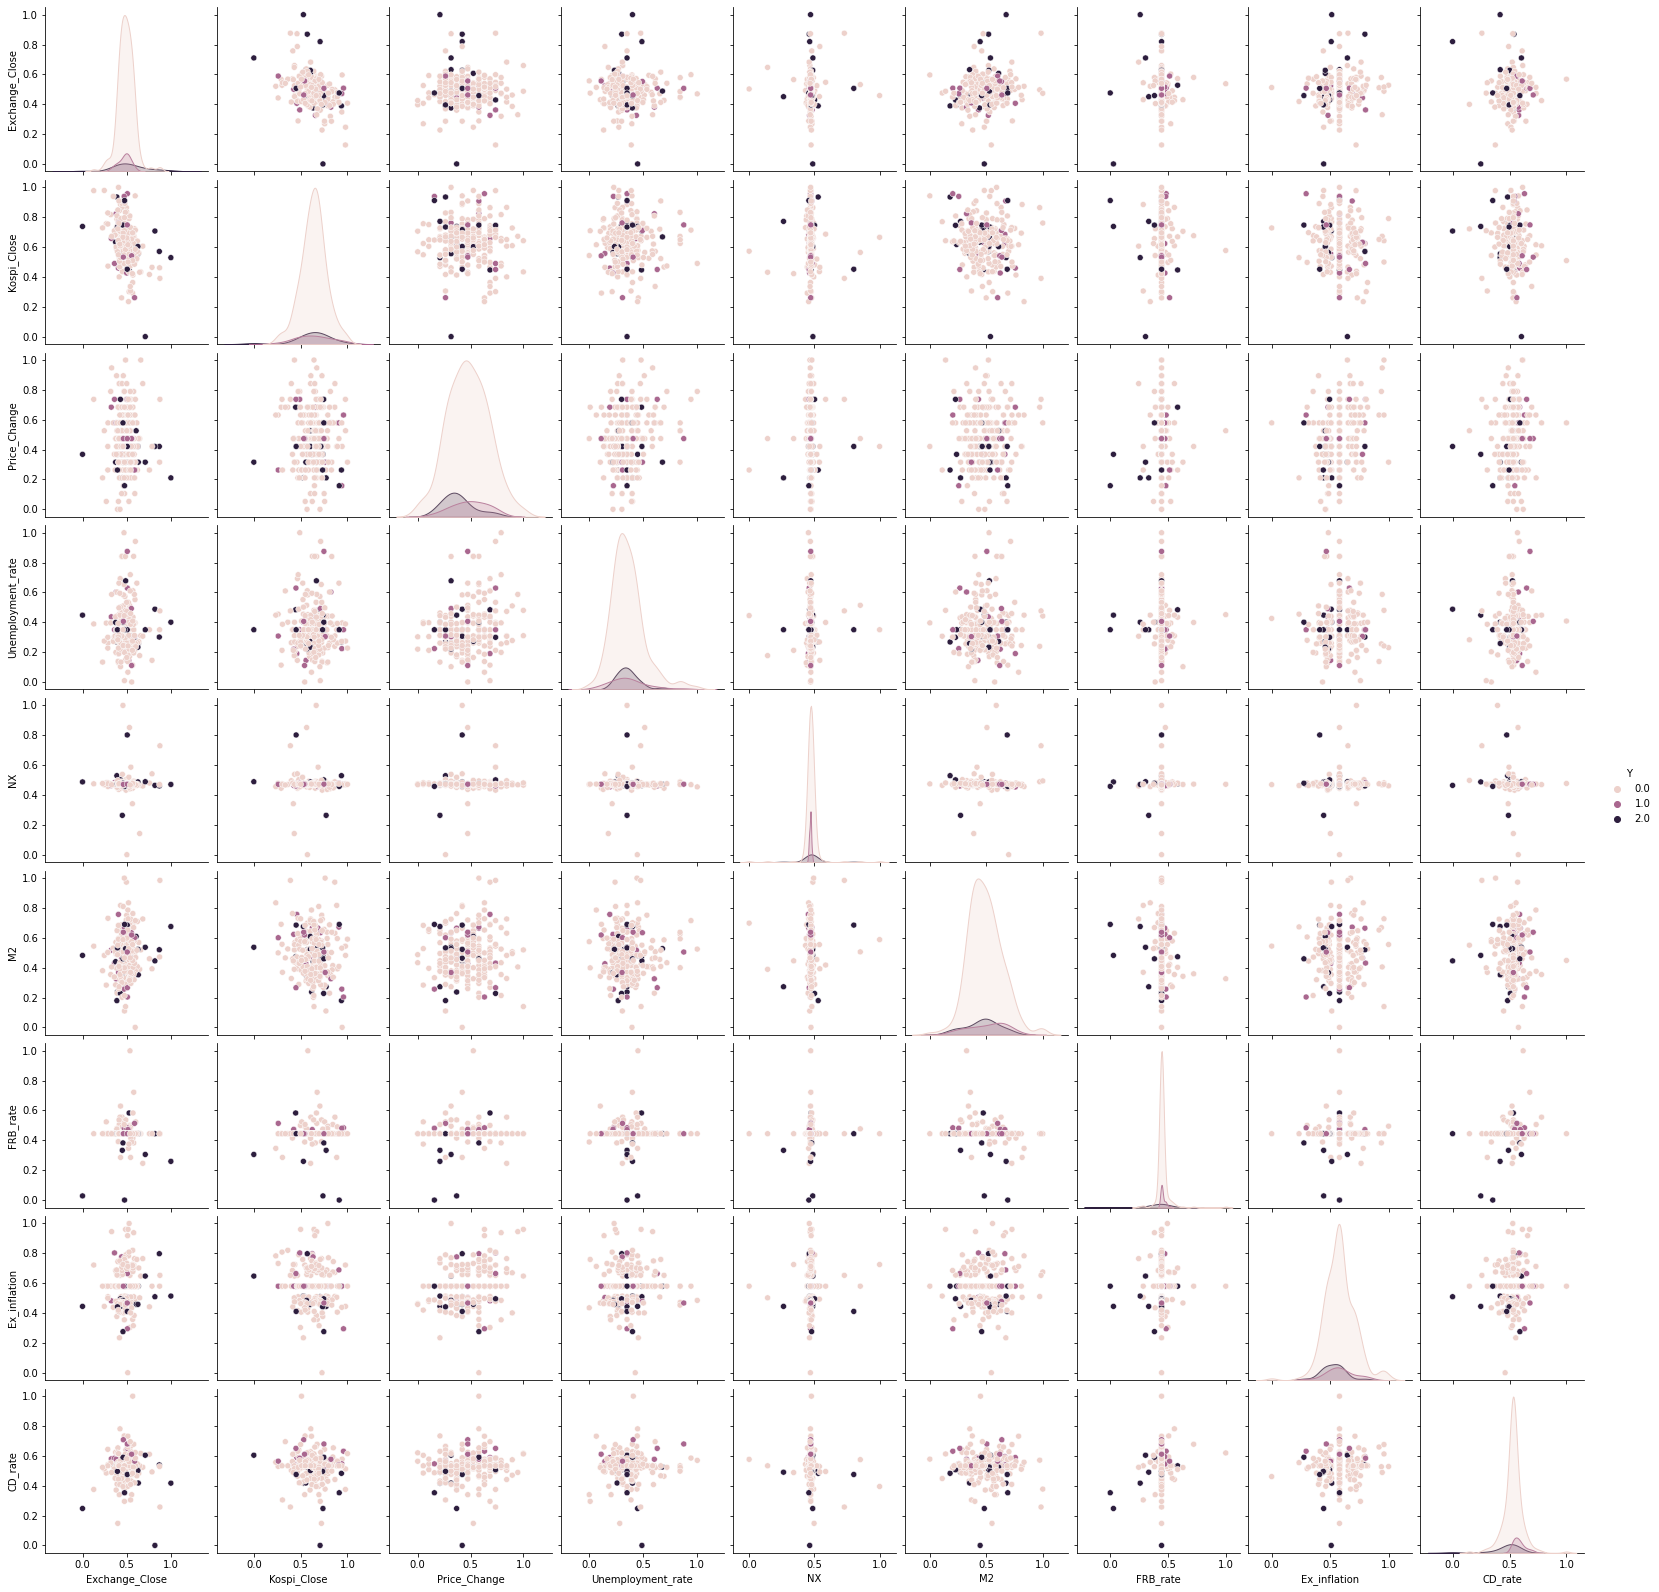

In [ ]:
sns.pairplot(df_Main_edit, hue='Y');
plt.show()

# 오버샘플링

In [ ]:
df_Main_edit["Y"].value_counts()

0.0    199
2.0     21
1.0     19
Name: Y, dtype: int64

In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.2 MB/s 
     |████████████████████████████████| 199 kB 56.3 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
x_data = df_Main_edit[['Exchange_Close','Kospi_Close','Price_Change','Unemployment_rate','NX','M2','FRB_rate','Ex_inflation','CD_rate']].values

y_data = df_Main_edit[['Y']].values
print(x_data.dtype, y_data.dtype)

x_data = x_data.astype('float32')
y_data = y_data.astype('float32')
print(x_data.dtype, y_data.dtype, y_data.shape, x_data.shape)

float64 float64
float32 float32 (239, 1) (239, 9)


Class=0, n=199 (33.333%)
Class=1, n=199 (33.333%)
Class=2, n=199 (33.333%)


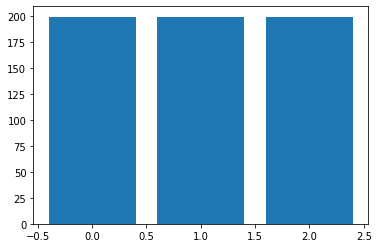

(597,)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
x_data,y_data=SMOTE(random_state=0).fit_resample(x_data,y_data)
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    plt.bar(counter.keys(), counter.values())
    plt.show()

count_and_plot(y_data)
y_data.shape

# 분석

In [ ]:
one_hot_dummy = tf.one_hot(y_data, depth=3).numpy()
y_data = one_hot_dummy
print(y_data.shape)

(597, 3)


In [ ]:
y_data

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,train_size=0.7, shuffle=True) #, random_state=1)

In [ ]:
print(x_train.shape,  y_train.shape)

# dataset parameters.
nb_features= x_train.shape[1] # the number of input variables, 18
nb_classes = y_train.shape[1] # the number of output group, 3    print(nb_inputs, nb_classes)
print(nb_features, nb_classes)

# training HyperParameters
learning_rate=0.1
epochs = 50000
batch_size = len(x_train)

# network hyperparameters
n_hidden_1 = 8 # 1st layer number of neurons. #hidden layer 2개
n_hidden_2 = 8 # 2nd layer number of neurons.

(417, 9) (417, 3)
9 3


In [ ]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

model = Sequential()  # 선언

model.add(Dense(units = n_hidden_1, activation='relu', input_shape=(nb_features,)))   # neuron, input column개수
model.add(Dropout(0.5))
model.add(Dense(n_hidden_2, activation='relu')) #units=7
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))   # ouput column개수 #output 한 개 #binary니까 sigmoid로 activation 설정
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 179
Trainable params: 179
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',   # y = not one-hot encoding but number
              optimizer='adam', #adam>RMSprop>SGD
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 47501/50000
1/1 - 0s - loss: 0.7109 - accuracy: 0.6595 - val_loss: 0.5547 - val_accuracy: 0.7611 - 34ms/epoch - 34ms/step
Epoch 47502/50000
1/1 - 0s - loss: 0.6786 - accuracy: 0.6978 - val_loss: 0.5586 - val_accuracy: 0.7556 - 34ms/epoch - 34ms/step
Epoch 47503/50000
1/1 - 0s - loss: 0.6777 - accuracy: 0.6954 - val_loss: 0.5621 - val_accuracy: 0.7556 - 39ms/epoch - 39ms/step
Epoch 47504/50000
1/1 - 0s - loss: 0.6921 - accuracy: 0.6763 - val_loss: 0.5654 - val_accuracy: 0.7500 - 29ms/epoch - 29ms/step
Epoch 47505/50000
1/1 - 0s - loss: 0.7247 - accuracy: 0.6763 - val_loss: 0.5667 - val_accuracy: 0.7500 - 32ms/epoch - 32ms/step
Epoch 47506/50000
1/1 - 0s - loss: 0.7229 - accuracy: 0.6595 - val_loss: 0.5677 - val_accuracy: 0.7444 - 34ms/epoch - 34ms/step
Epoch 47507/50000
1/1 - 0s - loss: 0.6864 - accuracy: 0.6859 - val_loss: 0.5679 - val_accuracy: 0.7444 - 31ms/epoch - 31ms/step
Epoch 47508/50000
1/1 - 0s - loss: 0.7432 - accuracy: 0.6403 - val_l

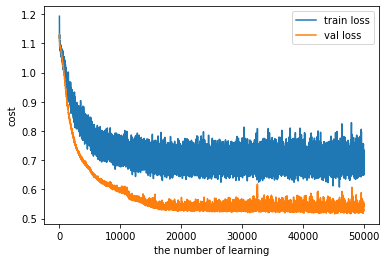

In [ ]:
plt.plot(history.history['loss'],     label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss') #test data 활용한 validation loss
plt.xlabel('the number of learning')
plt.ylabel('cost')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:',     score[0])
print('Train accuracy:', score[1])

score_test = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

Train loss: 0.4410364627838135
Train accuracy: 0.8393285274505615
Test loss: 0.4410364627838135
Test accuracy: 0.8393285274505615


[[ 72  33  34]
 [  0 142   0]
 [  0   0 136]]


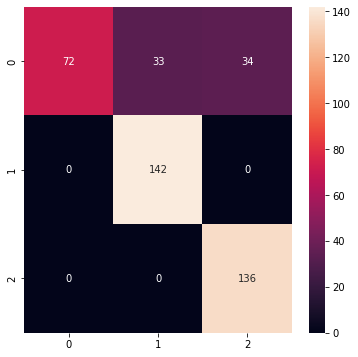

train
Report = 
               precision    recall  f1-score   support

           0       1.00      0.52      0.68       139
           1       0.81      1.00      0.90       142
           2       0.80      1.00      0.89       136

    accuracy                           0.84       417
   macro avg       0.87      0.84      0.82       417
weighted avg       0.87      0.84      0.82       417

test
Report = 
               precision    recall  f1-score   support

           0       1.00      0.30      0.46        60
           1       0.66      1.00      0.80        57
           2       0.83      1.00      0.91        63

    accuracy                           0.77       180
   macro avg       0.83      0.77      0.72       180
weighted avg       0.83      0.77      0.72       180



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#y_test = tf.one_hot(y_test, depth=nb_classes)

plt.figure(figsize=(6,6))
predict_value = model.predict(x_train)
cm = confusion_matrix(np.argmax(y_train, axis=-1), np.argmax(predict_value, axis=-1))
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print('train')
from sklearn.metrics import classification_report
y_actual    = np.argmax(y_train, axis=-1)
y_predicted = np.argmax(predict_value, axis=-1)
print('Report = \n', classification_report(y_actual, y_predicted))

print('test')
predict_value = model.predict(x_test)
y_actual    = np.argmax(y_test, axis=-1)
y_predicted = np.argmax(predict_value, axis=-1)
print('Report = \n', classification_report(y_actual, y_predicted))
# macro avg, 단순평균
# weighted avg, 각 셀에 속하는 표본의 갯수로 가중평균

In [ ]:
from sklearn.metrics import roc_curve
# train
fpr, tpr, thresholds = roc_curve(y_train, model.predict(x_train)) # (y_true, y_pred)
fpr, tpr, thresholds # false positive ratio(=fall-out), true positive ratio(=recall)
print(fpr, tpr, thresholds)

from sklearn.metrics import auc
print('AUC = ', auc(fpr, tpr))

plt.plot(fpr, tpr, 'o-', label="MLP")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('FallOut, FPR')
plt.ylabel('Recall, TPR')
plt.title('ROC curve')
plt.legend()
plt.show()


#test
fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test)) 
fpr, tpr, thresholds # false positive ratio(=fall-out), true positive ratio(=recall)
print(fpr, tpr, thresholds)
print('AUC = ', auc(fpr, tpr))

plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('FallOut, FPR')
plt.ylabel('Recall, TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

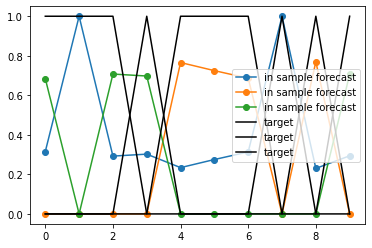

In [ ]:
in_sample_forecast = model.predict(x_train[:10])

plt.plot(in_sample_forecast, 'o-', label='in sample forecast')
plt.plot(y_train[:10], 'k-',   label='target')
plt.legend(loc='best')
plt.show() # 학습 결과. 0이면 호황, 1이면 불황. 학습을 많이 시키면 에러가 0에 가까움 ㅋ 보여주기용~ 

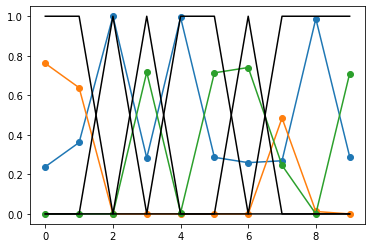

In [ ]:
# out-of-sample.
out_of_forecast = model.predict(x_test[:10])

plt.plot(out_of_forecast, 'o-', label='out of sample forecast')
plt.plot(y_test[:10], 'k-', label='true values')
#plt.legend(loc='best')
plt.show() # test 데이터의 성과. 검은 선이 실제 값이고 파란 색이 모형에서 예측한 값. 5, 6번 2개 밖에 안틀림. 80%의 정확도.